# Affinity of West Eurasians to present-day and ancient populations over time

In [1]:
library(here)
library(tidyverse)
library(parallel)
library(future)
library(furrr)
library(forcats)
library(ggrepel)
library(patchwork)
library(glue)

library(admixr)
library(bdkn)

plan(multiprocess)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse


Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
samples <- load_samples() %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

### Population assignments

In [3]:
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian", "Druze", "Iranian", "Samaritan")

In [4]:
populations <- list(
    "EastAsia" = c(filter(samples, pop == "EastAsia")$name, "TY"),
    "SouthAsia" = filter(samples, pop == "SouthAsia")$name,
    "Oceania" = filter(samples, pop == "Oceania")$name,
    "WestAfrica" = c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica" = c("Mbuti", "Biaka"),
    "EastAfrica" = c("Dinka", "BantuKenya", "Luhya", "Luo", "Masai", "Somali"),
    "SouthAfrica" = c("Khomani_San", "Ju_hoan_North")
)

In [5]:
ancient_X <- filter(samples, pop == "EMH", name %notin% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia")$name

### EIGENSTRAT data

In [6]:
snps <- eigenstrat(here("data/eigenstrat/bigyri_ho/all"))

In [7]:
snps_tv <- eigenstrat(here("data/eigenstrat/bigyri_ho/all")) %>% admixr::remove_transitions()

In [8]:
snps_pops <- eigenstrat(here("data/eigenstrat/bigyri_ho/all")) %>%
    relabel(EastAsia = c(filter(samples, pop == "EastAsia")$name, "TY"),
            SouthAsia = filter(samples, pop == "SouthAsia")$name,
            Oceania = filter(samples, pop == "Oceania")$name,
            WestAfrica = c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
            CentralAfrica = "Mbuti",
            EastAfrica = c("Dinka", "BantuKenya", "Luhya", "Luo", "Masai", "Somali"),
            SouthAfrica = c("Khomani_San", "Ju_hoan_North")
    )

In [9]:
wgs_snps <- eigenstrat(here("data/eigenstrat/whole_genome/whole_genome"))

In [10]:
snp_counts_f4 <- count_snps(snps)

In [11]:
# Function for plotting f4 statistics vs individual samples, as opposed to whole superpopulations
plot_ind <- function(df, p) {
    filter(df, nsnps > 100000, target_pop == p) %>% 
    ggplot(aes(age, f4, color = Y, shape = X %in% near_east)) +
        geom_point() +
        facet_wrap(~ Y) + xlim(40000, 0) +
        ggtitle(glue("f4(Kostenki14, X; {p}, Chimp)")) +
        geom_hline(yintercept = 0) + coord_cartesian(y = c(-0.01, 0.003)) +
        theme(legend.position = "bottom")
}

## Kostenki14 with Chimp as an outgroup

In [12]:
affinity_chimp_ko14 <- future_map_dfr(names(populations), function(pop) {
    ancient <- f4(W = "Kostenki14", X = ancient_X, Y = populations[[pop]], Z = "Chimp", data = snps)
    modern <- f4(W = "Kostenki14", X = modern_X, Y = populations[[pop]], Z = "Chimp", data = snps)
    bind_rows(ancient, modern) %>% mutate(target_pop = pop)
}) %>% inner_join(samples, by = c("X" = "name"))

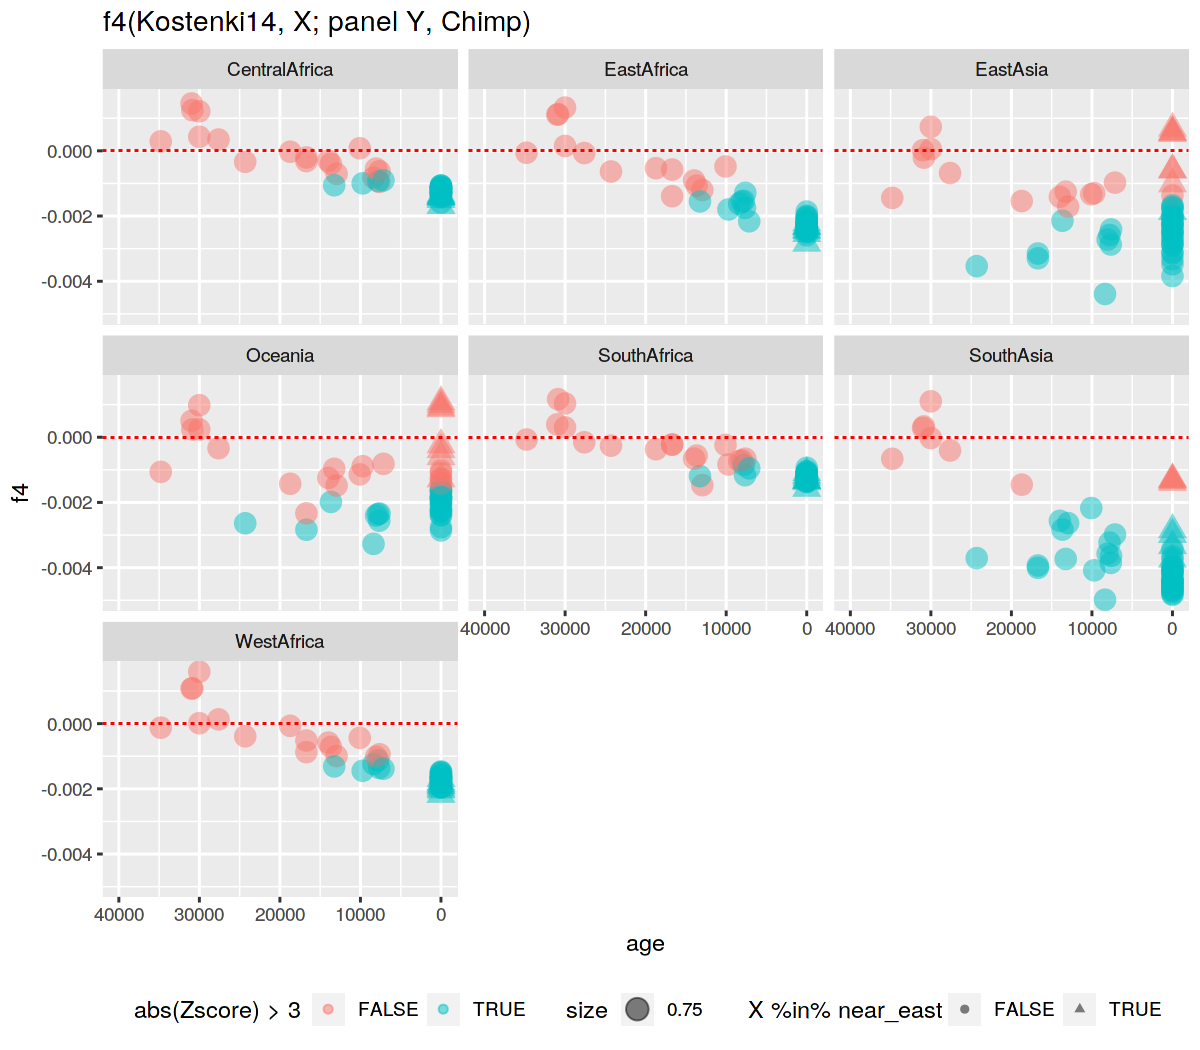

In [13]:
set_dim(8, 7)

filter(affinity_chimp_ko14, nsnps > 100000) %>%
group_by(target_pop, X, age) %>%
summarise(f4 = mean(f4), Zscore = mean(Zscore), nsnps = mean(nsnps)) %>% 
ggplot(aes(age, f4, shape = X %in% near_east)) +
    geom_point(aes(size = 0.75, color = abs(Zscore) > 3), alpha = 0.5) +
    facet_wrap(~ target_pop) + xlim(40000, 0) +
    geom_hline(yintercept = 0, color = "red", linetype = 2) +
    ggtitle(glue("f4(Kostenki14, X; panel Y, Chimp)")) +
    theme(legend.position = "bottom")

In [14]:
saveRDS(affinity_chimp_ko14, here("data/rds/affinity_chimp_ko14.rds"))

In [15]:
affinity_chimp_ko14 <- readRDS(here("data/rds/affinity_chimp_ko14.rds"))

## Ust-Ishim with Chimp as an outgroup

In [16]:
affinity_chimp_ui <- future_map_dfr(names(populations), function(pop) {
    ancient <- f4(W = "UstIshim", X = ancient_X, Y = populations[[pop]], Z = "Chimp", data = snps)
    modern <- f4(W = "UstIshim", X = modern_X, Y = populations[[pop]], Z = "Chimp", data = snps)
    bind_rows(ancient, modern) %>% mutate(target_pop = pop)
}) %>% inner_join(samples, by = c("X" = "name"))

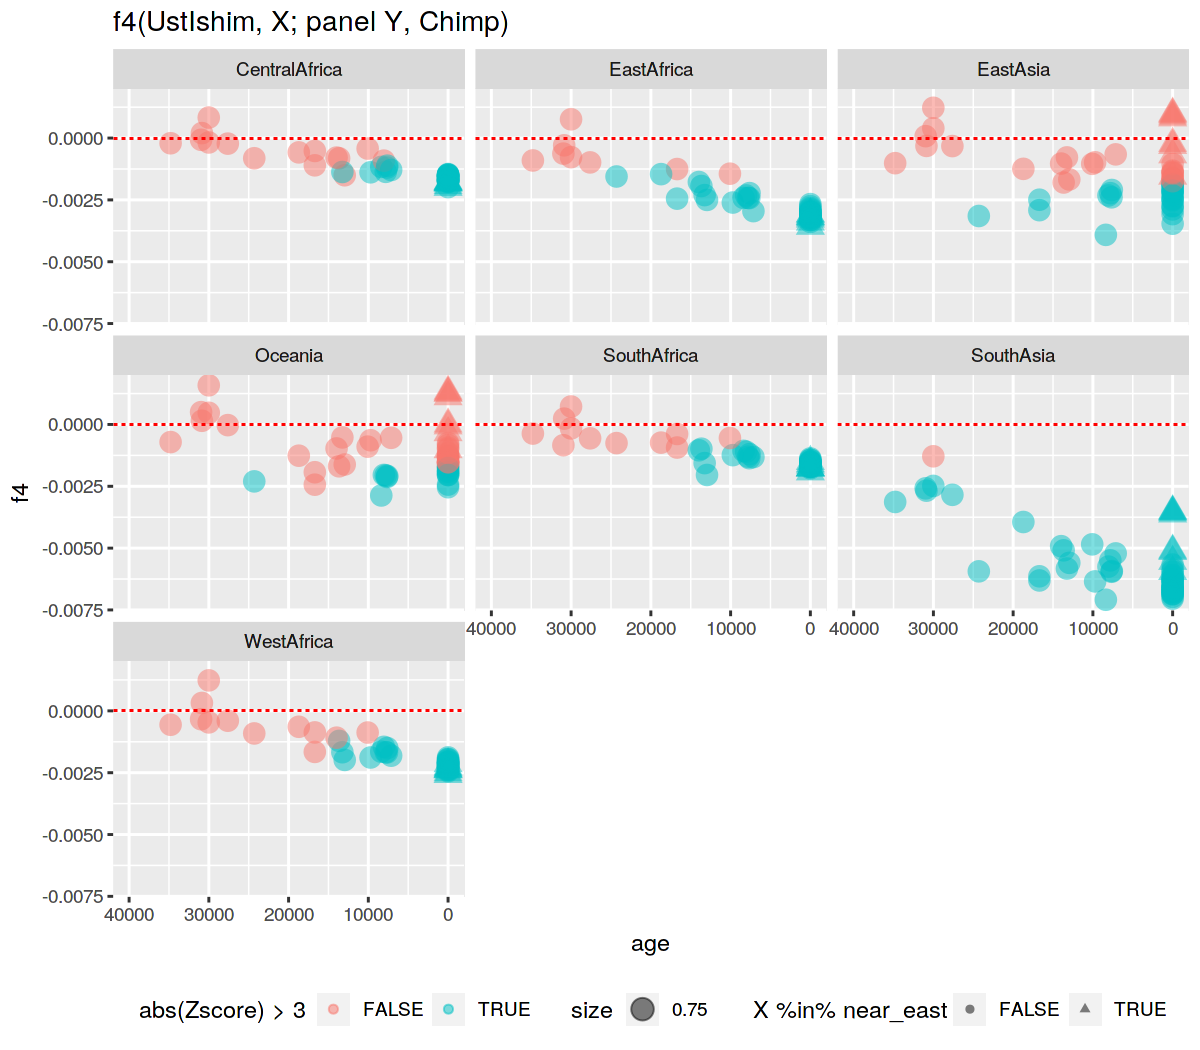

In [17]:
set_dim(8, 7)

filter(affinity_chimp_ui, nsnps > 100000) %>%
group_by(target_pop, X, age) %>%
summarise(f4 = mean(f4), Zscore = mean(Zscore), nsnps = mean(nsnps)) %>% 
ggplot(aes(age, f4, shape = X %in% near_east)) +
    geom_point(aes(size = 0.75, color = abs(Zscore) > 3), alpha = 0.5) +
    facet_wrap(~ target_pop) + xlim(40000, 0) +
    geom_hline(yintercept = 0, color = "red", linetype = 2) +
    ggtitle(glue("f4(UstIshim, X; panel Y, Chimp)")) +
    theme(legend.position = "bottom")

In [18]:
saveRDS(affinity_chimp_ui, here("data/rds/affinity_chimp_ui.rds"))

In [19]:
affinity_chimp_ui <- readRDS(here("data/rds/affinity_chimp_ui.rds"))

## Basal Eurasian ancestry analysis

In [20]:
zcut <- 3
snpcut <- 500000

In [21]:
ancient_eur <- filter(samples, pop == "EMH", name != "UstIshim")$name %>% str_replace("new_", "")
modern_eur <- filter(samples, pop == "WestEurasia")$name

### f4(WestEur, East Asian or early hunter gatherer; Ust-Ishim, Chimp)

In [22]:
ancient_f4 %<-% f4(W = ancient_X, X = c("Han", "Kostenki14"), Y="UstIshim", Z="Chimp", data = snps)
modern_f4  %<-% f4(W = modern_X, X = c("Han", "Kostenki14"), Y="UstIshim", Z="Chimp", data = snps)

In [23]:
basal_eur <- inner_join(bind_rows(ancient_f4, modern_f4), samples, by = c("W"="name"))

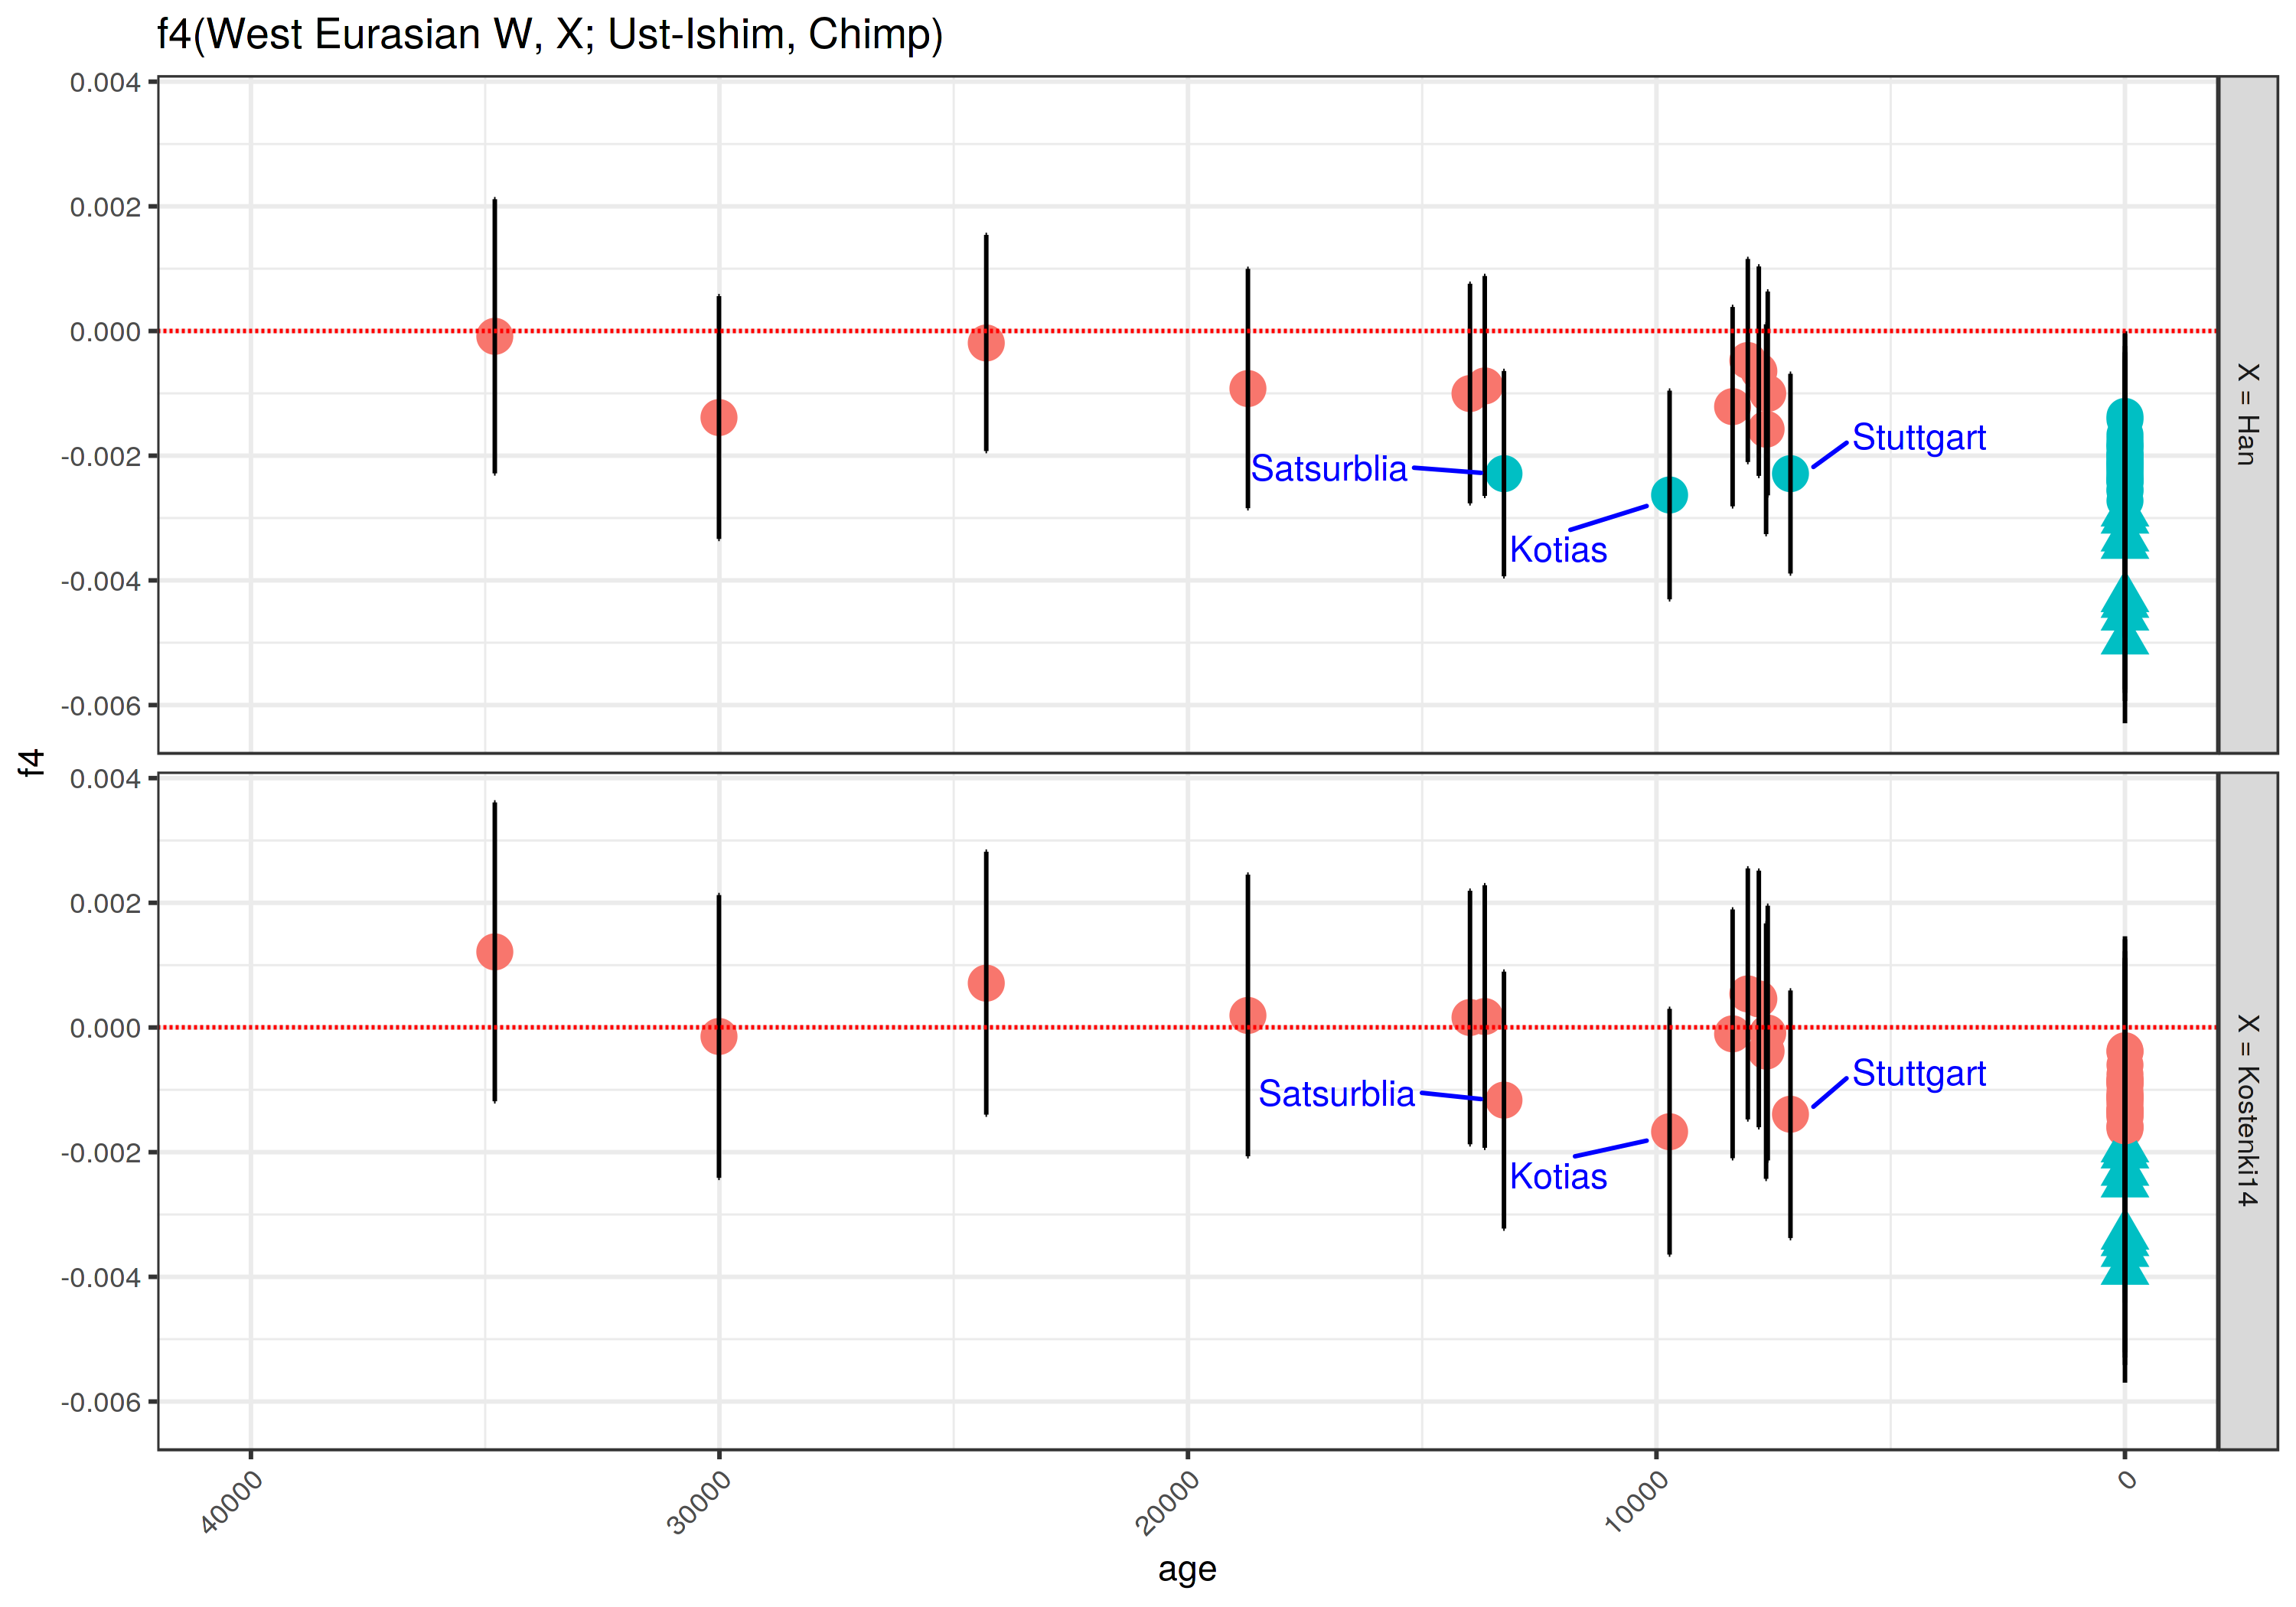

In [24]:
set_dim(10, 7, 300)

filter(basal_eur, nsnps > 500000) %>%
mutate(lbl = ifelse(W %in% c("Stuttgart", "Satsurblia", "Kotias"), W, ""),
       X = paste("X =", X)) %>% 
  ggplot(aes(age, f4)) +
  geom_point(aes(shape = W %in% near_east, color = abs(Zscore) > 3), size = 5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr)) +
  geom_hline(yintercept = 0, linetype = 2, color = "red") +
  geom_text_repel(aes(label = lbl), box.padding = 0.35, point.padding = 1, color = "blue") +
  ggtitle("f4(West Eurasian W, X; Ust-Ishim, Chimp)") +
  theme_bw() + facet_grid(X ~ .) +
  theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45)) +
  xlim(40000, 0)

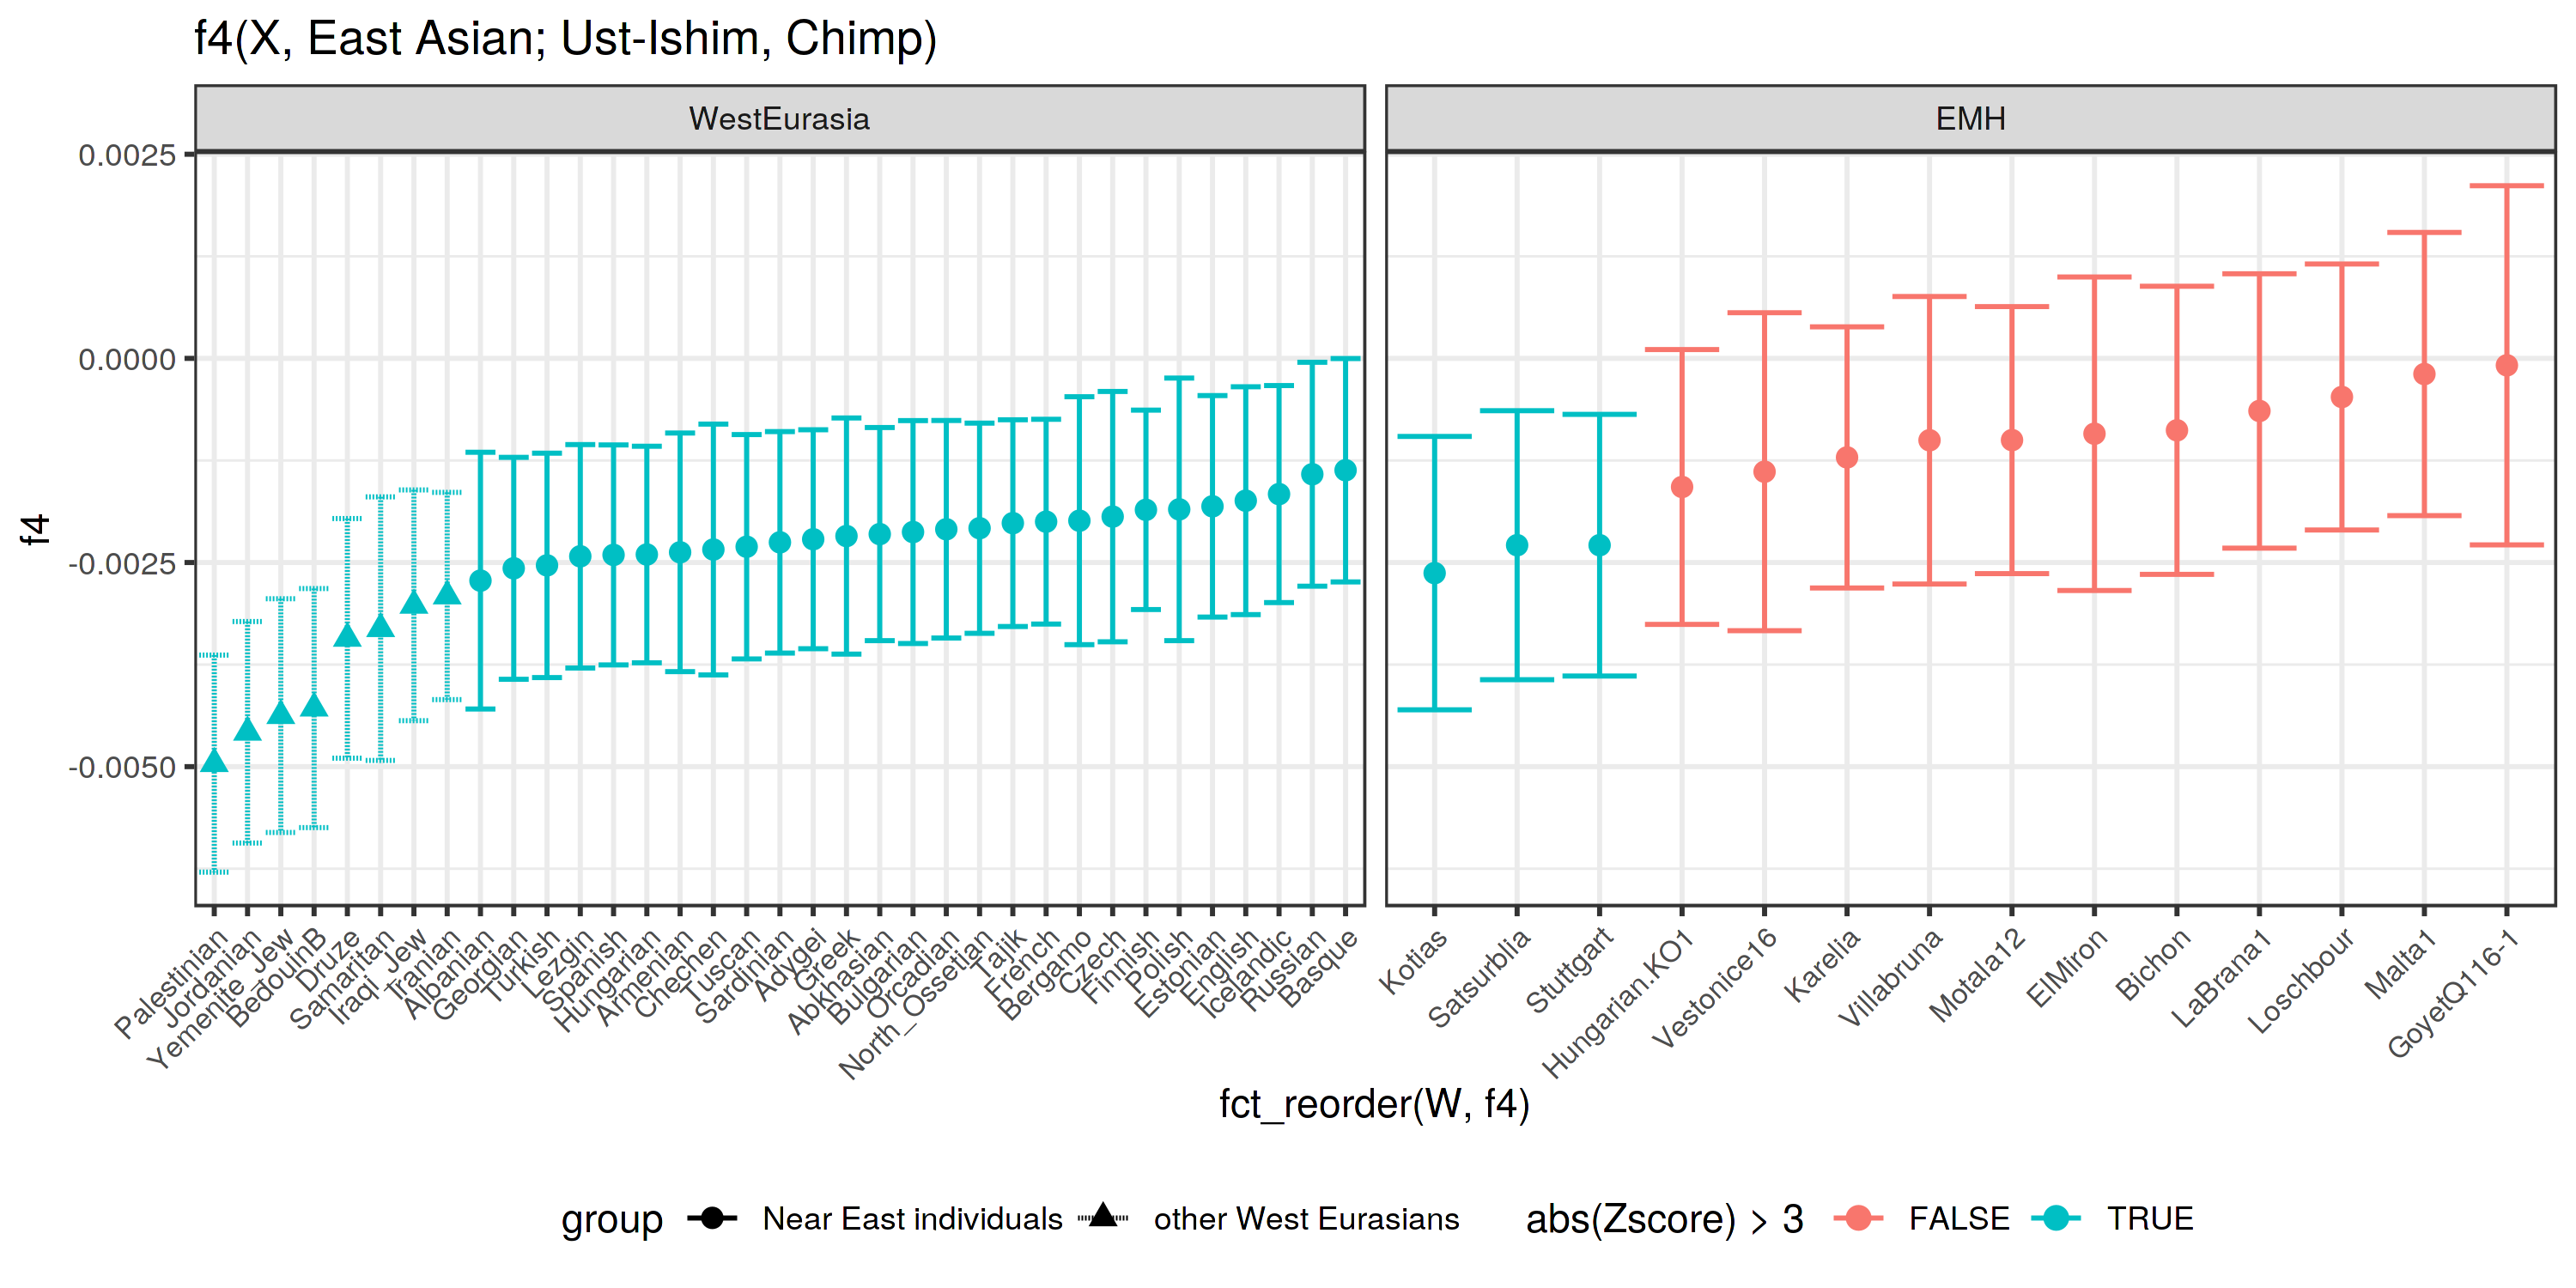

In [25]:
set_dim(10, 5, 300)

filter(basal_eur, X == "Han", nsnps > 500000) %>% 
  mutate(pop = factor(pop, levels = c("WestEurasia", "EMH")),
         group = ifelse(! W %in% near_east, "Near East individuals", "other West Eurasians")) %>% 
  ggplot(aes(fct_reorder(W, f4), f4, shape = group, color = abs(Zscore) > 3)) +
  geom_point(size = 2.5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr, linetype = group)) +
  ggtitle("f4(X, East Asian; Ust-Ishim, Chimp)") +
  theme_bw() +
  facet_wrap(~ pop, scales = "free_x") +
  theme(legend.position = "bottom", axis.text.x = element_text(size = 8, hjust = 1, angle = 45))

In [26]:
saveRDS(basal_eur, here("data/rds/basal_eur_array.rds"))

In [27]:
basal_eur <- readRDS(here("data/rds/basal_eur_array.rds"))

## Whole-genome analysis of basal Eurasian admixture vs Neandertal ancestry

In [28]:
basal_eur_wgs %<-% f4(W = filter(samples, pop == "WestEurasia")$name, X = "Han", Y = "new_UstIshim", Z = "Chimp", data = wgs_snps)

In [29]:
basal_eur_wgs <- inner_join(basal_eur_wgs, samples, by = c("W" = "name"))

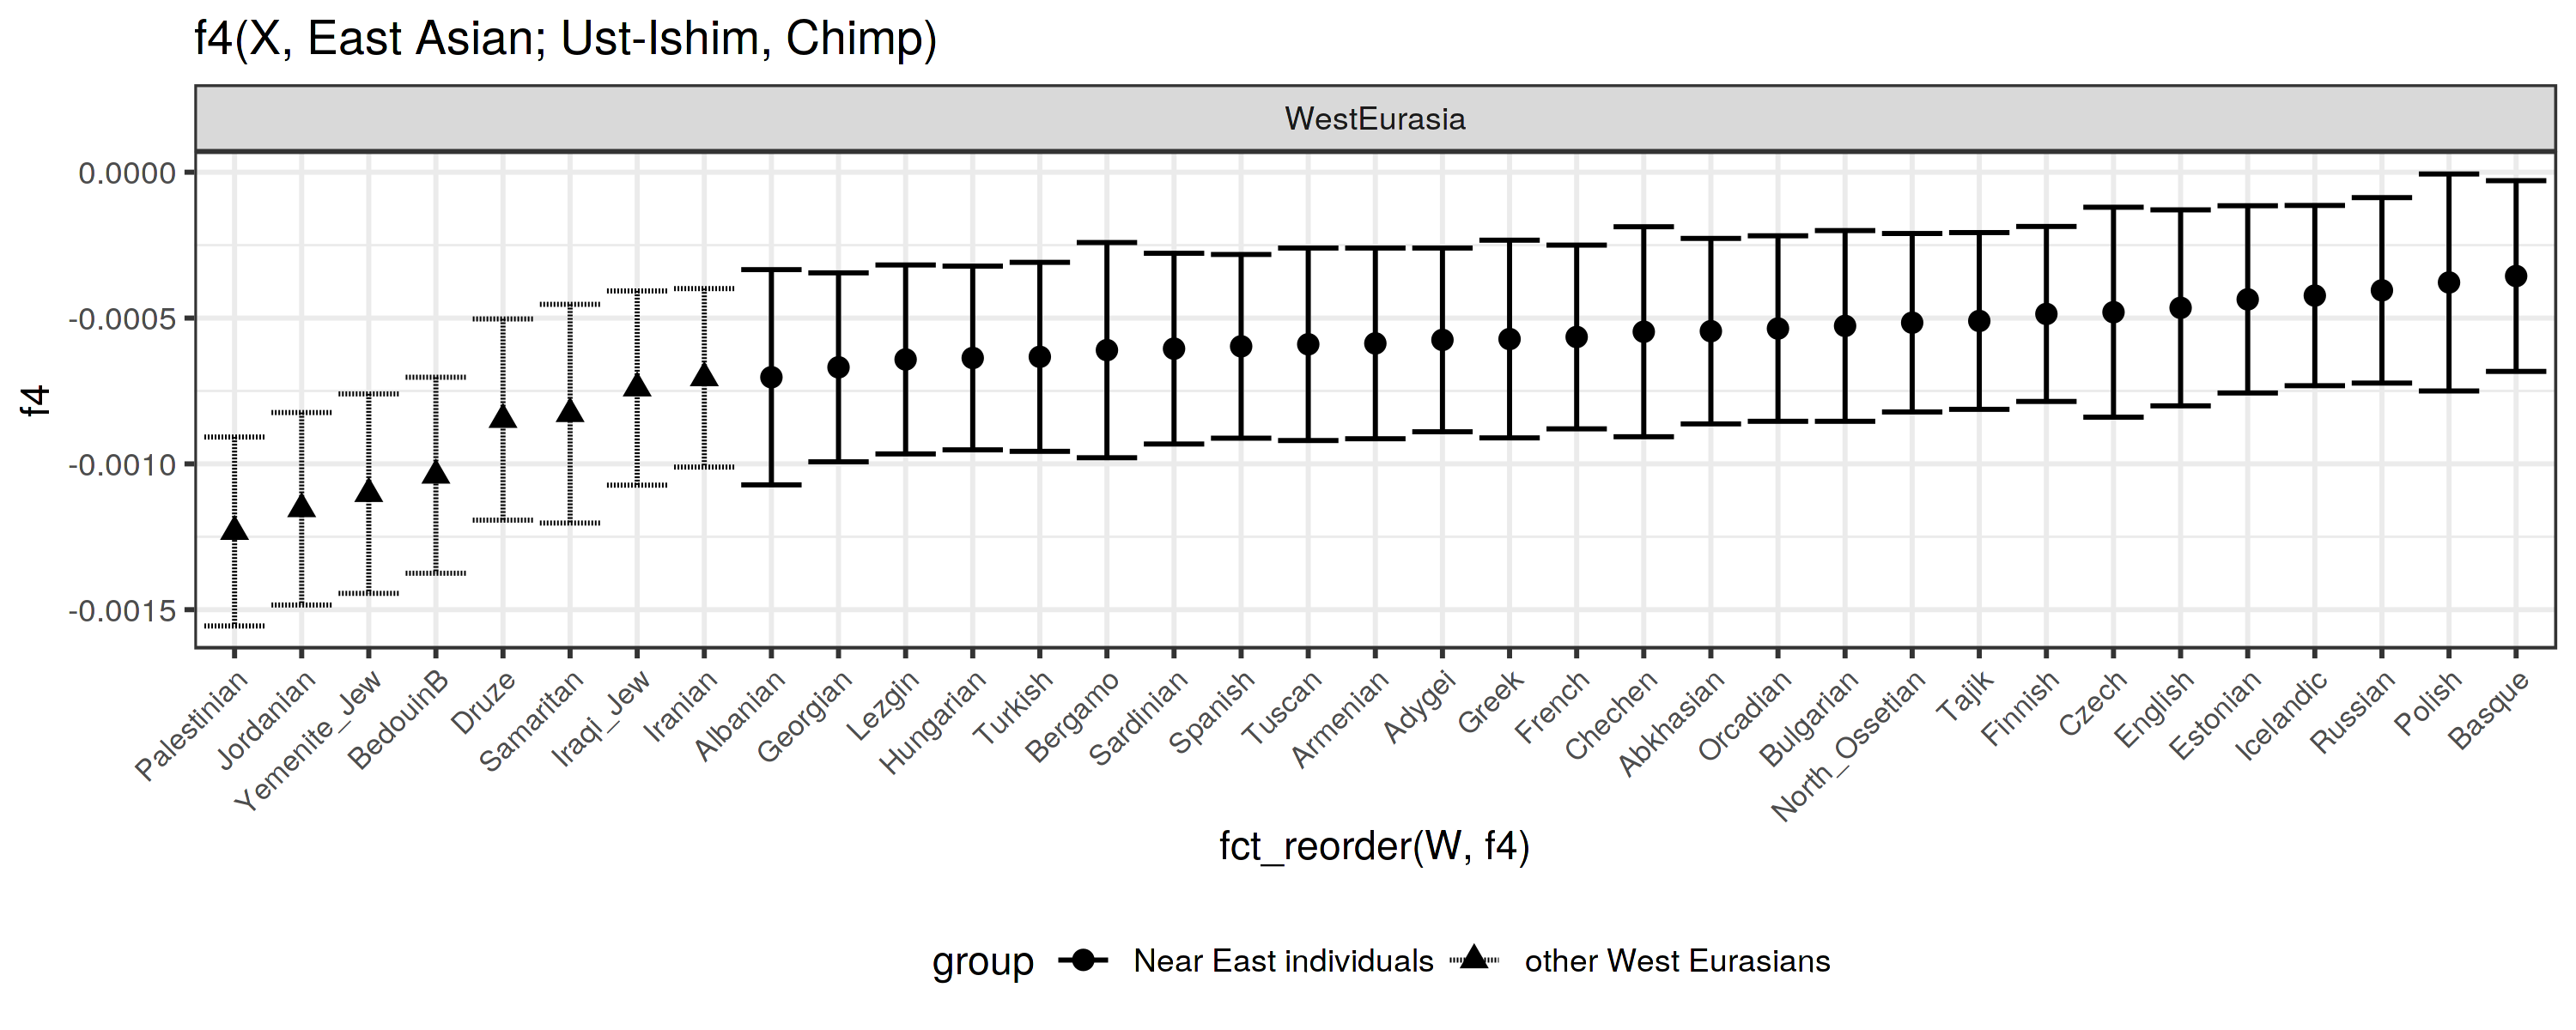

In [30]:
set_dim(10, 4, 300)

filter(basal_eur_wgs, X == "Han", pop == "WestEurasia") %>% 
  mutate(pop = factor(pop, levels = c("WestEurasia", "EMH")),
         group = ifelse(! W %in% near_east, "Near East individuals", "other West Eurasians")) %>% 
  ggplot(aes(fct_reorder(W, f4), f4, shape = group)) +
  geom_point(size = 2.5) +
  geom_errorbar(aes(ymin = f4 - 3 * stderr, ymax = f4 + 3 * stderr, linetype = group)) +
  ggtitle("f4(X, East Asian; Ust-Ishim, Chimp)") +
  theme_bw() +
  facet_wrap(~ pop, scales = "free_x") +
  theme(legend.position = "bottom", axis.text.x = element_text(size = 8, hjust = 1, angle = 45))

In [31]:
nea_wgs %<-% f4ratio(
    X = filter(samples, pop == "WestEurasia")$name,
    A = "new_Altai", B = "new_Vindija", C = "Dinka", O = "Chimp",
    data = wgs_snps
)

In [32]:
nea_be_wgs <- inner_join(
    select(nea_wgs, name = X, alpha),
    select(basal_eur_wgs, name = W, pop, f4, age, stderr)
) %>%
    mutate(group = case_when(name %in% near_east ~ "Near East",
                             pop == "EMH" ~ "EMH",
                             TRUE ~ "other West Eurasians"),
           name = ifelse(age == 0, name, paste0(name, " (", as.integer(age / 1000), " ky)"))) %>%
    filter(pop == "WestEurasia")

Joining, by = "name"


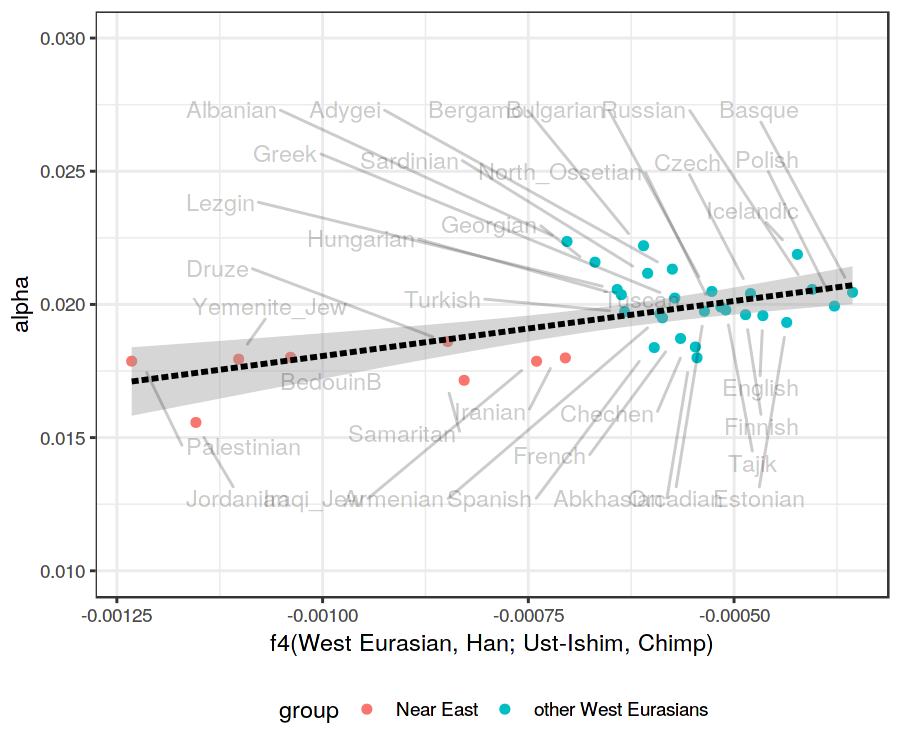

In [33]:
set_dim(6, 5)

nea_be_wgs %>% 
ggplot(aes(f4, alpha, color = group)) +
    geom_point() +
    geom_smooth(method = "lm", linetype = 5, color = "black", aes(group = 1)) +
    geom_text_repel(color = "black", aes(label = name), box.padding = 3, point.padding = 1, alpha = 1/5) +
    #geom_errorbarh(aes(xmin = f4 - 3 * stderr, xmax = f4 + 3 * stderr)) +
    theme_bw() + theme(legend.position = "bottom") +
    xlab("f4(West Eurasian, Han; Ust-Ishim, Chimp)") + ylim(0.01, 0.03)

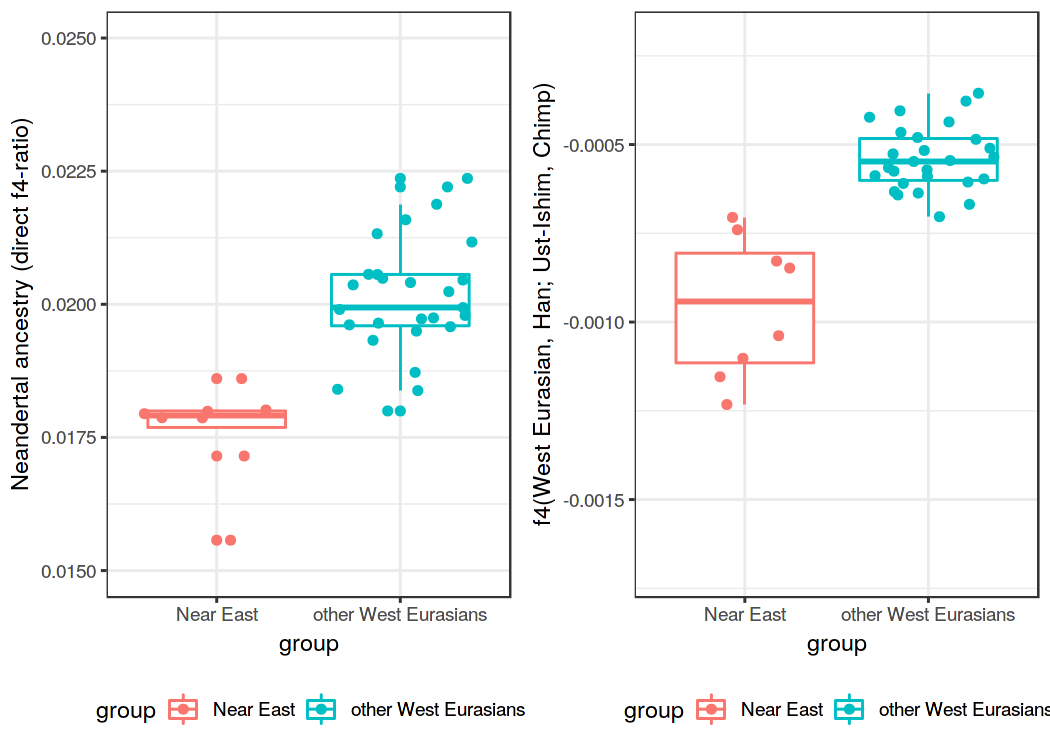

In [34]:
set_dim(7, 5)

ggplot(nea_be_wgs, aes(group, alpha, color = group)) +
    geom_boxplot() + geom_jitter() +
    theme_bw() + theme(legend.position = "bottom") +
    ylab("Neandertal ancestry (direct f4-ratio)") +
    ylim(0.015, 0.025) +

ggplot(nea_be_wgs, aes(group, f4, color = group)) +
    geom_boxplot() + geom_jitter() +
    theme_bw() + theme(legend.position = "bottom") +
    ylab("f4(West Eurasian, Han; Ust-Ishim, Chimp)") +
    ylim(-0.0017, -0.0002)

In [35]:
saveRDS(nea_be_wgs, here("data/rds/nea_be_wgs.rds"))

In [36]:
nea_be_wgs <- readRDS(here("data/rds/nea_be_wgs.rds"))

# Addressing some [Twitter comments](https://twitter.com/iosif_lazaridis/status/1014704269335912453).

D(Eastern non African, West Eurasian; African, Chimp) - is the relationship between non-Africans to Africans asymmetrical?

In [37]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
iosif_d <- future_map_dfr(c("Dinka", "Yoruba", "Mbuti", "Khomani_San"), function(pop) {
    map_dfr(c("Papuan", "Han", "TY", "BedouinB"), function(W) {
        ancient <- d(W = W, X = ancient_X, Y = pop, Z = "Chimp", data = snps)
        modern <- d(W = W, X = modern_X[modern_X %notin% near_east], Y = pop, Z = "Chimp", data = snps)

        bind_rows(ancient, modern)
    })
})

In [38]:
iosif_d <- inner_join(iosif_d, samples, by = c("X" = "name"))

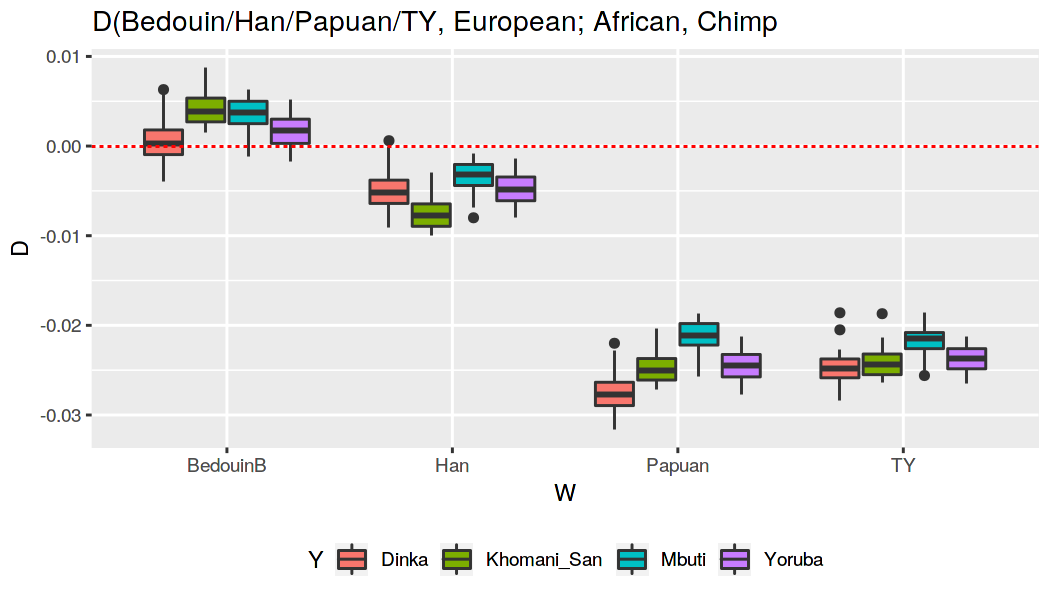

In [39]:
set_dim(7, 4, 150)

filter(iosif_d, pop != "EMH") %>%
ggplot(aes(W, D, fill = Y)) +
    geom_boxplot() +
    geom_hline(yintercept = 0, linetype = 2, color = "red") +
    theme(legend.position = "bottom") +
    ggtitle("D(Bedouin/Han/Papuan/TY, European; African, Chimp")

# Test whether D over time could reflect different amounts of archaic ancestry

**f4(UI, Papuan; Afr, San)** and **f4(UI, Papuan; Afr, Chimp)**

Can the f4-over-time analysis pick up changes in Neandertal ancestry? Let's test by comparing Papuan (lot of archaic ancestry) with UI (much less archaic ancestry and no Denisova ancestry).

In [40]:
f4(W = "UstIshim", X = "Papuan", Y = c("Dinka", "Yoruba", "Mbuti", "Khomani_San"), Z = "Chimp", data = snps)

W,X,Y,Z,f4,stderr,Zscore,BABA,ABBA,nsnps
UstIshim,Papuan,Dinka,Chimp,0.000277,0.000352,0.785,86919,86370,1984253
UstIshim,Papuan,Yoruba,Chimp,0.000101,0.000324,0.312,86386,86186,1984277
UstIshim,Papuan,Mbuti,Chimp,0.000124,0.000266,0.467,78071,77824,1984279
UstIshim,Papuan,Khomani_San,Chimp,0.000307,0.000267,1.150,74766,74157,1984023


In [41]:
f4(W = "UstIshim", X = "Papuan", Y = c("Dinka", "Yoruba", "Mbuti"), Z = "Khomani_San", data = snps)

W,X,Y,Z,f4,stderr,Zscore,BABA,ABBA,nsnps
UstIshim,Papuan,Dinka,Khomani_San,-0.000071,0.000300,-0.236,87633,87778,2050077
UstIshim,Papuan,Yoruba,Khomani_San,-0.000232,0.000284,-0.815,88104,88579,2050098
UstIshim,Papuan,Mbuti,Khomani_San,-0.000175,0.000221,-0.794,79899,80258,2050098


Do Papuans have enough archaic ancestry on the 2.2M array for this test to be meaningful?

In [42]:
f4ratio(X = c("UstIshim", "Papuan", "Han", "French"), A = "new_Altai", B = "new_Vindija", C = "Dinka", O = "Chimp", data = snps)

A,B,X,C,O,alpha,stderr,Zscore
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.025595,0.003804,6.727
new_Altai,new_Vindija,Papuan,Dinka,Chimp,0.033049,0.003052,10.829
new_Altai,new_Vindija,Han,Dinka,Chimp,0.024842,0.002930,8.479
new_Altai,new_Vindija,French,Dinka,Chimp,0.020490,0.002652,7.727


What is the ratio of Nea ancestry in UstIshim vs Papuans?

In [43]:
filter(.Last.value, X == "UstIshim")$alpha / filter(.Last.value, X == "Papuan")$alpha

[1] 0.7744561

## TY x Han showing similar temporal pattern to what we see with ancient x present EUR

In [44]:
ui_vs_ty <- d(
    W = "UstIshim",
    X = c("TY", "Vestonice16", "GoyetQ116-1", "Kostenki14", "ElMiron",
          "Villabruna", "Han", "Loschbour", "French", "Sardinian", "Onge", "Papuan"),
    Y = c("Yoruba", "Dinka", "Mbuti"),
    Z = "Chimp",
    data = snps
)

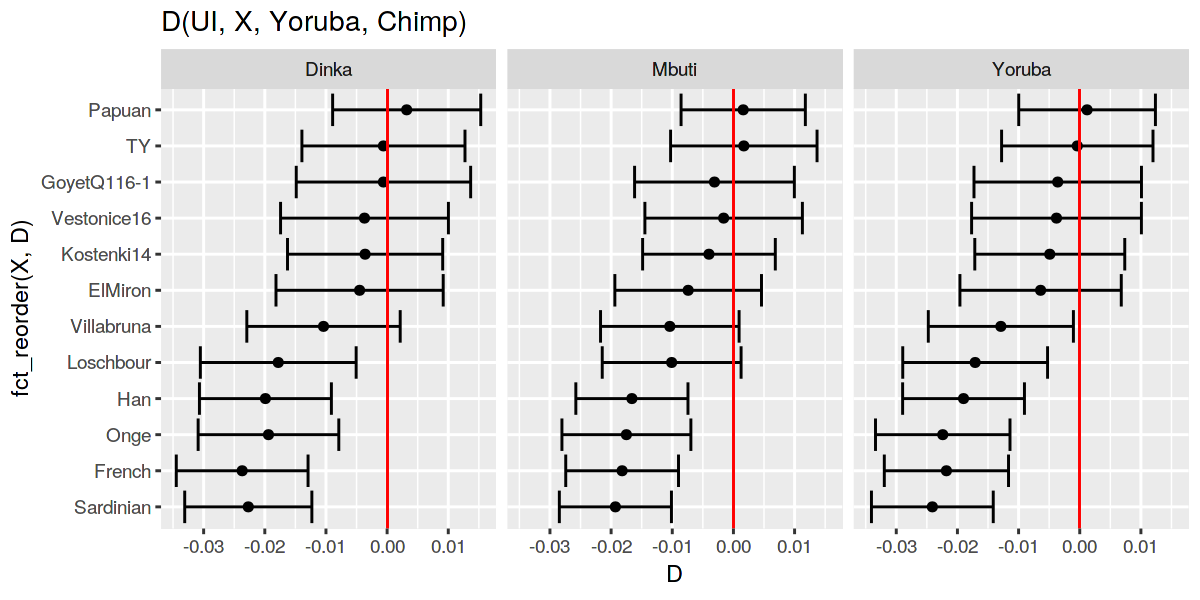

In [45]:
set_dim(8, 4)

ggplot(ui_vs_ty, aes(fct_reorder(X, D), D)) +
    geom_point() +
    geom_errorbar(aes(ymin = D - 3 * stderr, ymax = D + 3 * stderr)) +
    geom_hline(yintercept = 0, color = "red") + coord_flip() +
    ggtitle("D(UI, X, Yoruba, Chimp)") + facet_wrap(~ Y)

## Schraiber's suggestion

Alternative way of looking at our D-over-time signal that doesn't rely on UstIshim, but uses a present-day West Eurasian instead.

In [46]:
schraiber <- future_map_dfr(str_subset(names(populations), "Africa"), function(pop) {
    bind_rows(
        f4(W = "French", X = c("UstIshim", "Kostenki14", ancient_X), Y = pop, Z="Chimp", data = snps_pops),
        f4(W = "French", X = discard(modern_X, ~ .x == "French"), Y = pop, Z = "Chimp", data = snps_pops)
    )
}) %>% inner_join(samples, by=c("X"="name"))

Warning message:
“Removed 4 rows containing missing values (geom_point).”

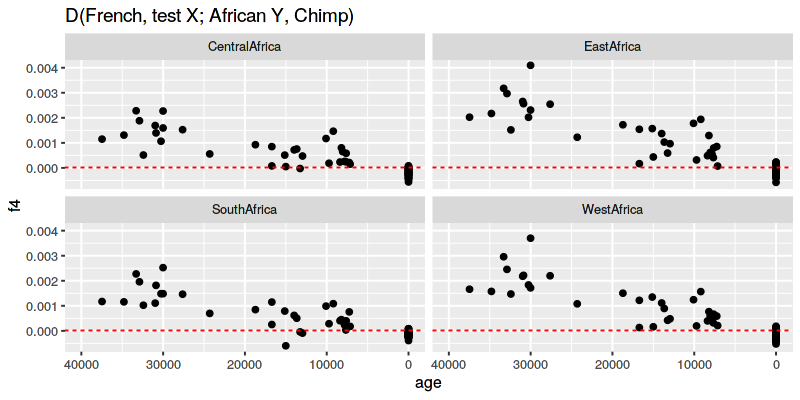

In [47]:
set_dim(8, 4, 100)
schraiber %>% 
filter(nsnps >= 50000) %>% 
ggplot(aes(age, f4)) +
    geom_point() +
    ggtitle("D(French, test X; African Y, Chimp)") +
    geom_hline(yintercept = 0, color = "red", linetype = 2) +
    facet_wrap(~ Y) +
    xlim(40000, 0)